In [ ]:
#This code is to compare ATE Estimation with various DML method 
#  Method 1: Simple OLD,  Y = theta D + g(x) +e
#  Method 2: Naive DML,   theta = sum(Vi (Yi - g(x)) / sum (Vi Di)
#  Method 3: cross-fitting DML 

In [1]:
# loading Python packages 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.linalg import toeplitz

# Step 1: data generation
np.random.seed(123)
N = 500    # Number of observations
k = 8     # Number of predictors X
theta = 0.5  # True treatment effect
b = 1 / np.arange(1, k+1)  # Coefficients for X

def generate_corr_matrix(k, seed = None):
    if seed is not None:
        np.random.seed(seed)
        
    A = np.random.randn(k, k)
    A2 = A @ A.T   # Positive matrix 
    D = np.sqrt(np.diag(A2))
    corr_mat = A2 / np.outer(D, D)
    np.fill_diagonal(corr_mat, 1.0)
    
    return corr_mat
    
sig_mat = generate_corr_matrix(k)
print('Correlation of X: \n', sig_mat)

mu_mat = np.zeros(k)
print('\nExpected X:', mu_mat)

Correlation of X: [[ 1.         -0.32943402  0.22378727  0.26602137  0.548024   -0.6821969
  -0.03598284  0.09775228]
 [-0.32943402  1.          0.02402343  0.01752641 -0.41365028 -0.00520886
   0.32703253 -0.35174582]
 [ 0.22378727  0.02402343  1.         -0.56367661 -0.24839403 -0.57244015
   0.45612898  0.50639001]
 [ 0.26602137  0.01752641 -0.56367661  1.          0.29202959 -0.07415771
  -0.36243243  0.05479484]
 [ 0.548024   -0.41365028 -0.24839403  0.29202959  1.          0.02332847
  -0.51553996 -0.22024295]
 [-0.6821969  -0.00520886 -0.57244015 -0.07415771  0.02332847  1.
  -0.31024999 -0.37013154]
 [-0.03598284  0.32703253  0.45612898 -0.36243243 -0.51553996 -0.31024999
   1.         -0.13837819]
 [ 0.09775228 -0.35174582  0.50639001  0.05479484 -0.22024295 -0.37013154
  -0.13837819  1.        ]]

Expected X: [0. 0. 0. 0. 0. 0. 0. 0.]


In [2]:
# Step 2: Estimate ATE with M simulation 
# setup parameters
M = 200        # M simulations
theta_hat_rf = np.full((M, 3), np.nan)   # Estimates for OLS, Naive DML and cross-fitting DML

# Loop
for i in range(M):
    #print(f"This is simulation {i+1} out of {M} simulations")
    if i % 10 == 0:
        print(f"This is simulation {i+1} out of {M} simulations")
    
    X = np.random.multivariate_normal(mu_mat, sig_mat, N) 
    m = np.sin(X @ b) + np.cos(X @ b) 
    d = m + np.random.normal(size=N)  # D = m(x) + e
    g = np.cos(X @ b)**2    
    y = theta * d + g + np.random.normal(size=N)  # Y = theta D + g(X) + e
    
    # OLS estimate
    ols_model = LinearRegression()
    ols_model.fit(np.column_stack([d, X]), y)   # OLS regression of Y on X and d
    theta_hat_rf[i, 0] = ols_model.coef_[0]    # theta_OLS
    
    # Naive DML 
    model_rf_g = RandomForestRegressor(n_estimators=100, max_depth=10)
    model_rf_g.fit(X, y)
    G_rf = model_rf_g.predict(X)
    
    model_rf_d = RandomForestRegressor(n_estimators=100, max_depth=10)
    model_rf_d.fit(X, d)
    M_rf = model_rf_d.predict(X)
    ed_rf = d - M_rf
    
    theta_nv_rf = np.mean(ed_rf * (y - G_rf)) / np.mean(ed_rf * d)
    theta_hat_rf[i, 1] = theta_nv_rf  # theta_Naive
    
    # Cross-fitting DML
    I = np.sort(np.random.choice(N, size=N // 2, replace=False))    # First half
    IC = np.setdiff1d(np.arange(N), I)    # Second half
      
    rf_g1 = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
    rf_g1.fit(X[IC], y[IC])
    G_rf1 = rf_g1.predict(X[I])
    
    rf_g2 = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
    rf_g2.fit(X[I], y[I])
    G_rf2 = rf_g2.predict(X[IC])
    
    rf_d1 = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
    rf_d1.fit(X[IC], d[IC])
    M_rf1 = rf_d1.predict(X[I])
    
    rf_d2 = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
    rf_d2.fit(X[I], d[I])
    M_rf2 = rf_d2.predict(X[IC])
    
    ed_rf1 = d[I] - M_rf1
    ed_rf2 = d[IC] - M_rf2
    
    theta_rf1 = np.mean(ed_rf1 * (y[I] - G_rf1)) / np.mean(ed_rf1 * d[I])
    theta_rf2 = np.mean(ed_rf2 * (y[IC] - G_rf2)) / np.mean(ed_rf2 * d[IC])
    
    theta_hat_rf[i, 2] = np.mean([theta_rf1, theta_rf2])


This is simulation 1 out of 200 simulations
This is simulation 11 out of 200 simulations
This is simulation 21 out of 200 simulations
This is simulation 31 out of 200 simulations
This is simulation 41 out of 200 simulations
This is simulation 51 out of 200 simulations
This is simulation 61 out of 200 simulations
This is simulation 71 out of 200 simulations
This is simulation 81 out of 200 simulations
This is simulation 91 out of 200 simulations
This is simulation 101 out of 200 simulations
This is simulation 111 out of 200 simulations
This is simulation 121 out of 200 simulations
This is simulation 131 out of 200 simulations
This is simulation 141 out of 200 simulations
This is simulation 151 out of 200 simulations
This is simulation 161 out of 200 simulations
This is simulation 171 out of 200 simulations
This is simulation 181 out of 200 simulations
This is simulation 191 out of 200 simulations


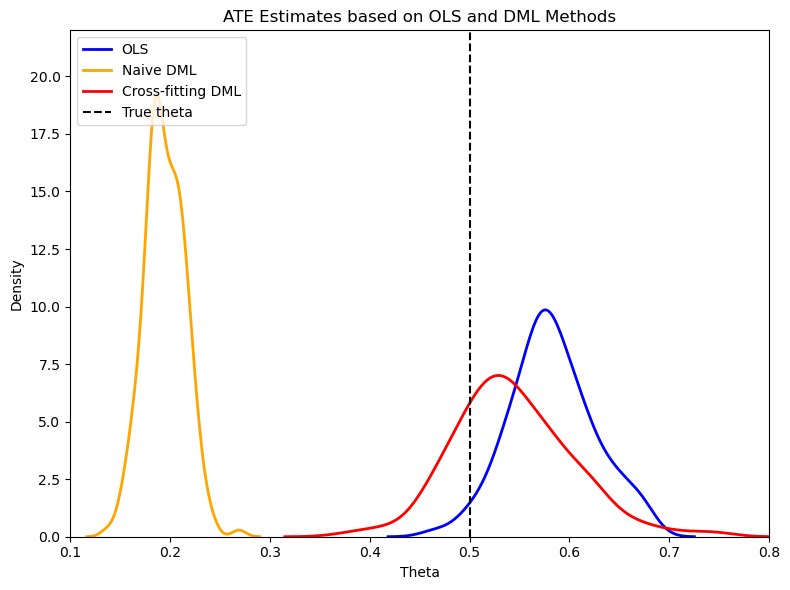

In [3]:
# Step 3 Visualize Estimates of three methods  
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# Plot title and axis labels
plt.title("ATE Estimates based on OLS and DML Methods")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.xlim(0.1, 0.8)
plt.ylim(0, 22)

# Plot density lines
sns.kdeplot(theta_hat_rf[:, 0], color='blue', label='OLS', linewidth=2)
sns.kdeplot(theta_hat_rf[:, 1], color='orange', label='Naive DML', linewidth=2)
sns.kdeplot(theta_hat_rf[:, 2], color='red', label='Cross-fitting DML', linewidth=2)

# True ATE line
plt.axvline(0.5, linestyle='--', color='black', label='True theta')


plt.legend(loc='upper left')
plt.tight_layout()
plt.show()